# Code for figures in problem a)

In this notebook we do experiments with minimising OLS and Ridge cost functions for the Franke function for different methods and hyperparametres

In [31]:
# IMPORT
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from Code.descent_methods import *

# Import the gradient methods
from Code.utilities import train_test_split, MSELoss_method

# Import the gradient methods
from Code.utilities import OLS_train_analgrad, OLS_train_autograd, ridge_train_analgrad, ridge_train_autograd

methods_dict_list = [
    {"name"   : "GD",       "method" : GD,           "color" : "C0"},
    {"name"   : "SGD",      "method" : SGD,          "color" : "C1"},
    {"name"   : "adagrad",  "method" : SGD_adagrad,  "color" : "C2"},
    {"name"   : "RMS prop", "method" : SGD_RMS_prop, "color" : "C3"},
    {"name"   : "adam",     "method" : SGD_adam,     "color" : "C4"}
]

# Import tools from the first project 
from Code.project1_tools import feature_matrix_2d, r2_sampling, scale_feature_matrix

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Used for nice legend
from matplotlib.lines import Line2D

import time as time

# Set the default font size for text elements (e.g., titles, labels)
import matplotlib as mpl
mpl.rcParams['font.size'] = 16  # Change 14 to your desired font size
mpl.rcParams['legend.fontsize'] = 14

In [32]:
### Fix a seed for sampling and initialisation to get consistent results
np.random.seed(41)

# Initialise beta
num_features = 10

# Start with small values
beta0 = {"b" : np.random.random(num_features)*0.1}

# Sample points and split in train and test
num_points = 100
split=0.2
data = r2_sampling(num_points)
x, y, z = data["x"], data["y"], data["z"]

# Scaling etc...
X = feature_matrix_2d(x, y, num_features)
X, means, var = scale_feature_matrix(X)
X_train, y_train, X_test, y_test, test_index = train_test_split(X, z, split)

# Squeeze to avoid errors due to shape [100, 1]
y_train, y_test = np.squeeze(y_train), np.squeeze(y_test)

# Define the polynomial fit model
def model(beta, X):
    return jnp.dot(X, beta["b"])

loss_func = MSELoss_method(model)

### Comparing the 4 gradients

0.5735716819763184
4.945148229598999
0.5175979137420654
8.160244941711426


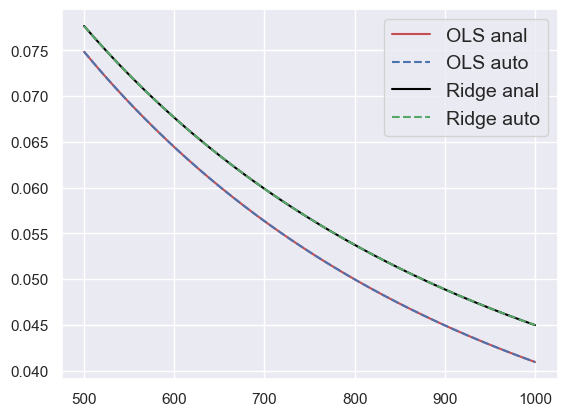

In [33]:
# Use even number (:
n_epochs = 1000

# Initialise test parameters
lam=0.1
lr = 0.05

# Loop
linestyles = ["r", "b--", "black", "g--"]
labels = ["OLS anal", "OLS auto", "Ridge anal", "Ridge auto"]
for i, loss_grad in enumerate([OLS_train_analgrad(model), OLS_train_autograd(model), 
                  ridge_train_analgrad(model, lam), ridge_train_autograd(model, lam)]):

    t0 = time.time()

    result_GD = GD(X_train, y_train, X_test, y_test, 
                grad_method=loss_grad, 
                n_epochs=n_epochs, 
                lr=lr,
                beta0=beta0, 
                test_loss_func=(MSELoss_method(model)))

    print(time.time()-t0)

    # Plot the second half of training
    plt.plot(np.arange(n_epochs//2, n_epochs+1, 1), result_GD["train_loss_list"][n_epochs//2::], linestyles[i], label=labels[i])

plt.legend()
plt.show()

See that anal and auto give same results, but automatic takes 10* as much time ---> we use analytic in the following!

Note also that Ridge takes twice as long for auto. This might be because we have 2 terms of jnpsum(jnppower)...

### Testing momentum 

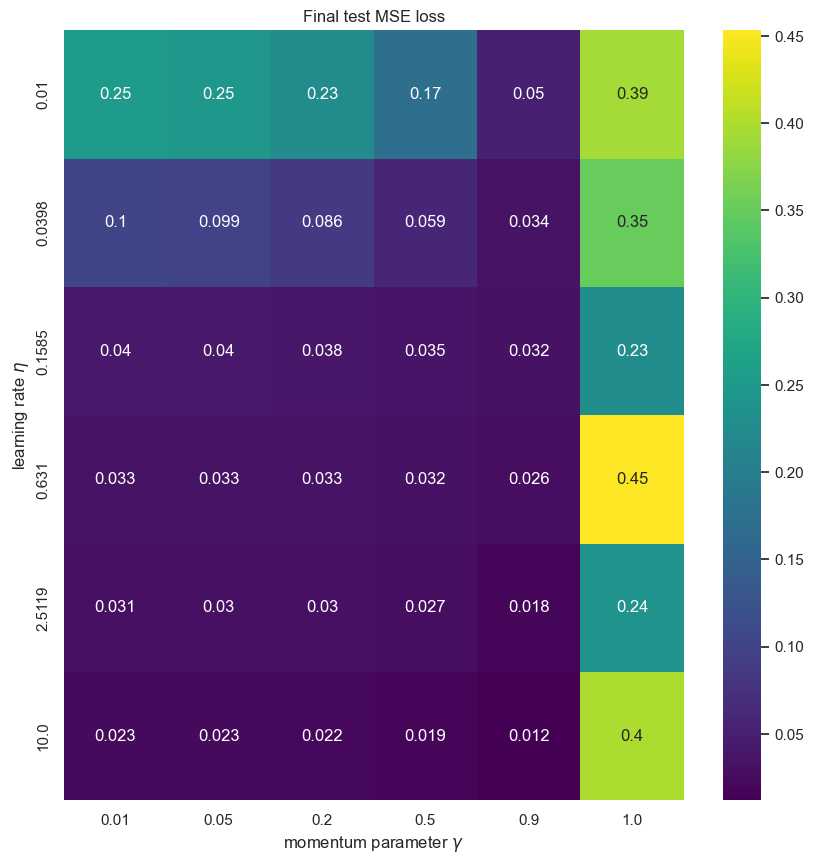

In [34]:
# ensure the same random numbers appear every time
np.random.seed(0)

# Fixed parametres
epochs = 1000

# Values for experiment
lr_vals = np.logspace(-2, 1, 6)
gamma_vals = np.array([0.01, 0.05, 0.2, 0.5, 0.9, 1])
results = np.zeros((len(lr_vals), len(gamma_vals)))

# We juse analytic ridge
grad_method= OLS_train_analgrad(model)

# Perform algorithm for each value
for i, lr in enumerate(lr_vals):
    for j, gamma in enumerate(gamma_vals):

        # Perform experiment
        result_GD = GD(X_train, y_train, X_test, y_test, 
                    grad_method=grad_method, 
                    n_epochs=epochs, 
                    lr=lr,
                    beta0=beta0, 
                    gamma=gamma,
                    test_loss_func=loss_func)

        # Append the final error from training
        results[i, j] = result_GD["test_loss_list"][-1]


# Make plot
sns.set()
fig, ax = plt.subplots(figsize = (10, 10))
df = pd.DataFrame(results, index=lr_vals, columns=gamma_vals)
sns.heatmap(df, annot=True, ax=ax, cmap="viridis",                  
            xticklabels=df.columns.values.round(4),
            yticklabels=df.index.values.round(4))
ax.set_title("Final test MSE loss")
ax.set_ylabel("learning rate $\eta$")
ax.set_xlabel("momentum parameter $\gamma$")

plt.show()

Here: discuss how gamma=1 results in "shift". Interpretation: here stack up all previous gradients. For gamma<1 we dampen the first... For gamma>1, would get exponential...

### Comparing the methods for different number of epochs

Final error for GD = 0.14328965544700623
Final error for SGD = 0.020723797380924225
Final error for adagrad = 0.017559383064508438
Final error for RMS prop = 0.00886606890708208
Final error for adam = 0.008915240876376629


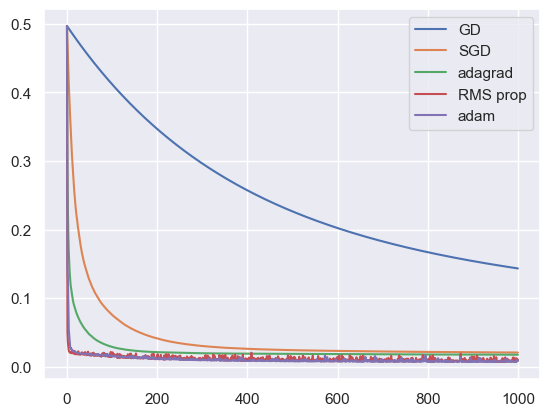

In [35]:
## We compare final train error to see "how far convergence has come"

# Use OLS analytic
loss_grad = OLS_train_analgrad(model)
lr = 0.01

# Max epoch number
n_epochs = 1000

def epoch_experiment(lr, n_epochs=n_epochs, loss_grad = loss_grad, methods_dict_list=methods_dict_list):

    # For methods with n_batches, the default 5 is used!
    n_batches = 5

    for method_dict in methods_dict_list:

        method_func = method_dict["method"]
        method_name = method_dict["name"]

        result = method_func(X_train, y_train, X_test, y_test, 
                grad_method=loss_grad, 
                n_epochs=n_epochs, 
                lr=lr,
                beta0=beta0, 
                test_loss_func=(MSELoss_method(model)))
            
        if method_name=="GD": # batch size 1
            plt.plot(result["train_loss_list"][::1], label=method_name)
        else:
            plt.plot(result["train_loss_list"][::n_batches], label=method_name)
        print(f"Final error for {method_name} = {result['train_loss_list'][-1]}")


    plt.legend()
    plt.show()

# epoch_experiment(0.001)
epoch_experiment(0.01)
# epoch_experiment(0.1)

### Learning rate experiment

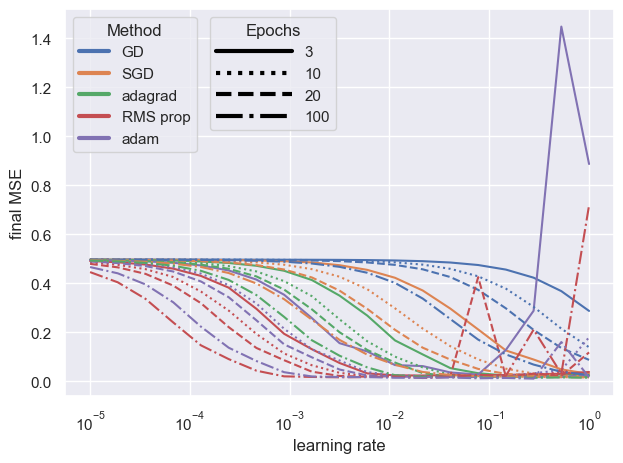

In [44]:
## We compare final train error to see "how far convergence has come"

# Use OLS analytic
loss_grad = OLS_train_analgrad(model)

### Define experiment
def lr_experiment(lr_values, n_epochs=3, methods_dict_list=methods_dict_list, linestyle='solid'):

    # For methods with n_batches, the default 5 is used!
    # n_batches = 5

    for method_dict in methods_dict_list:

        method_func = method_dict["method"]
        method_name = method_dict["name"]

        final_errors = []

        for lr in lr_values:

            result = method_func(X_train, y_train, X_test, y_test, 
                    grad_method=loss_grad, 
                    n_epochs=n_epochs, 
                    lr=lr,
                    beta0=beta0, 
                    test_loss_func=(MSELoss_method(model)))
            
            final_errors.append(result["train_loss_list"][-1])

        plt.plot(lr_values, final_errors, label=method_name, color=method_dict["color"], linestyle=linestyle)

    plt.xlabel("learning rate")
    plt.xscale("log")
    plt.ylabel("final MSE")

# Values for the learning rates
lr_values = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
lr_values = np.logspace(-5, 0, 19)

# Colors for legend
colors = [meth["color"] for meth in methods_dict_list]
meth_names = [meth["name"] for meth in methods_dict_list]

# Linestyles for legend
epoch_nums = [3, 10, 20, 100]
line_styles = ["solid", "dotted", "dashed", "dashdot"]
names = [f"{n}" for n in epoch_nums]


# A nice seed
np.random.seed(35)

for i in range(len(epoch_nums)):
    lr_experiment(lr_values, n_epochs=epoch_nums[i], linestyle=line_styles[i])

# Create custom handles for the legend
color_handles = [Line2D([0], [0], color=c, lw=3) for c in colors]
style_handles = [Line2D([0], [0], color='black', lw=3, linestyle=ls) for ls in line_styles]

# Create two legends, one for color and one for line style
legend_color = plt.legend(color_handles, meth_names, loc='upper left', title='Method', bbox_to_anchor=(0,1))
legend_style = plt.legend(style_handles, epoch_nums, loc='upper left', title='Epochs', bbox_to_anchor=(0.25,1), handlelength=5)

# Add the first legend manually to the plot
plt.gca().add_artist(legend_color)
plt.tight_layout()
plt.show()


In [37]:
"""
### analysis of results for OLS and RIDGE as function of
- lr
- mini batches
- #epochs
- algorithm

- lambda for ridge!
    - use seabord ... to show results as function of lr and lam !
"""


'\n### analysis of results for OLS and RIDGE as function of\n- lr\n- mini batches\n- #epochs\n- algorithm\n\n- lambda for ridge!\n    - use seabord ... to show results as function of lr and lam !\n'

### Mini batches

### Seaborn Ridge
Ridge as function of learning rate and lambda

use seabord ... to show results as function of lr and lam !


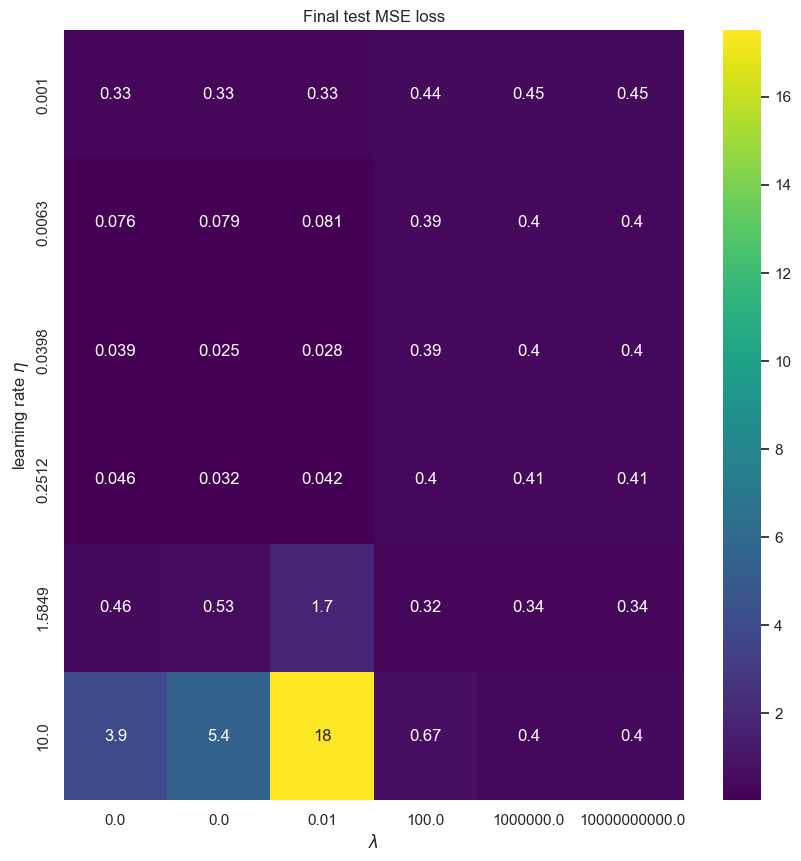

In [38]:
# ensure the same random numbers appear every time
np.random.seed(0)

# Fixed parametres
epochs = 10

# Values for experiment
lr_vals = np.logspace(-3, 1, 6)
lam_vals = np.logspace(-10, 10, 6)
results = np.zeros((len(lr_vals), len(lam_vals)))

# We juse analytic ridge
train_grad = ridge_train_analgrad

# Perform algorithm for each value
for i, lr in enumerate(lr_vals):
    for j, lam in enumerate(lam_vals):

        # Get gradient function for given lambda
        grad_method = train_grad(model, lam)

        # Perform experiment
        result_GD = SGD_adam(X_train, y_train, X_test, y_test, 
                    grad_method=grad_method, 
                    n_epochs=epochs, 
                    n_batches=5,
                    lr=lr,
                    beta0=beta0, 
                    test_loss_func=loss_func)

        # Append the final error from training
        results[i, j] = result_GD["test_loss_list"][-1]


# Make plot
sns.set()
fig, ax = plt.subplots(figsize = (10, 10))
df = pd.DataFrame(results, index=lr_vals, columns=lam_vals)
sns.heatmap(df, annot=True, ax=ax, cmap="viridis",                  
            xticklabels=df.columns.values.round(4),
            yticklabels=df.index.values.round(4))
ax.set_title("Final test MSE loss")
ax.set_ylabel("learning rate $\eta$")
ax.set_xlabel("$\lambda$")

plt.show()